<a href="https://colab.research.google.com/github/Schimmenti/EarthquakesGPS/blob/main/Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import time
from scipy.ndimage.filters import maximum_filter1d, minimum_filter1d
from google.colab import drive
from sklearn.metrics import roc_curve
drive.mount('/content/drive')


def max_filter1d_valid(a, W, add_heading_nan=True):
    hW = (W-1)//2 # Half window size
    if(add_heading_nan):
      return np.concatenate([np.ones(W-1)*np.nan,maximum_filter1d(a,size=W)[hW:-hW]])
    else:
      return maximum_filter1d(a,size=W)[hW:-hW]
def min_filter1d_valid(a, W, add_heading_nan=True):
    hW = (W-1)//2 # Half window size
    if(add_heading_nan):
      return np.concatenate([np.ones(W-1)*np.nan,minimum_filter1d(a,size=W)[hW:-hW]])
    else:
      return minimum_filter1d(a,size=W)[hW:-hW]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def haversine(lat1, lat2, delta_long):
  return np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(delta_long/2)**2

In [3]:
def moving_lin_regress(x, T, t0, t1, add_heading_nan=True):
    m = []
    for t in range(t0,t1-T):
        m.append(stats.linregress(np.arange(0,T),x[t:t+T])[0])
    if(add_heading_nan):
      return np.concatenate([np.ones(T)*np.nan, np.array(m)])
    else:
      return np.array(m)

In [4]:
base_link = "https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/"

In [5]:
! wget "https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/stat_info.pkl"

--2022-03-14 13:13:28--  https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/stat_info.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17030 (17K) [application/octet-stream]
Saving to: ‘stat_info.pkl’

stat_info.pkl       100%[===================>]  16.63K  --.-KB/s    in 0s      

2022-03-14 13:13:28 (78.3 MB/s) - ‘stat_info.pkl’ saved [17030/17030]



In [6]:
with open("stat_info.pkl","rb") as handle:
  station_names, station_pos = pkl.load(handle)

# Processing

In [ ]:
stat_data = {}
for name in station_names:
  try:
    stat_data[name] = pd.read_csv(base_link + name + ".csv")
  except:
    continue

In [ ]:
for name in stat_data.keys():
  #decimal_years  = stat_data[name]["DateD"].values
  #years = np.trunc(decimal_years).astype('int')
  #days_in_year = 365*np.ones(len(years), dtype=int)
  #days_in_year[days_in_year%4==0] += 1
  #days = np.round((decimal_years-years)*days_in_year).astype('int')
  #starting_date = datetime.date(years[0], 1, 1)
  #delta_days = datetime.timedelta(int(days[0]) - 1)
  #starting_date += delta_days
#
  #ending_date = datetime.date(years[-1]-1, 12, 31)
  #delta_days = datetime.timedelta(int(days[-1]))
  #ending_date += delta_days
  #print(ending_date)
  #del stat_data[name]["Date"]

  stat_data[name]['Date'] = pd.to_datetime(stat_data[name]['DateI'], format='%Y%m%d')
  stat_data[name].set_index("Date", drop=True, inplace=True)
  idx = pd.date_range(stat_data[name].index[0], stat_data[name].index[-1])
  stat_data[name] = stat_data[name].reindex(idx, fill_value=np.NaN)

In [ ]:
with open("stat_data.pkl", "wb") as handle:
  pkl.dump(stat_data,handle)

In [ ]:
W=9
coefs = {}
for name in stat_data.keys():
  nord = stat_data[name]["N"].values
  T_w_nord = moving_lin_regress(nord, W, 0, len(nord))
  east = stat_data[name]["E"].values
  T_w_east = moving_lin_regress(east, W, 0, len(east))
  up = stat_data[name]["U"].values
  T_w_up = moving_lin_regress(up, W, 0, len(up))
  coefs[name] = np.array([T_w_nord, T_w_east, T_w_up])

In [ ]:
with open("T_W=%i.pkl"%W, "wb") as handle:
  pkl.dump(coefs,handle)

# Loading

In [7]:
catalog = pd.read_csv("https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/catalog.csv",sep=r"\s+", index_col="Date")

In [8]:
W=9
with open("drive/MyDrive/Colab Notebooks/T_W=%i.pkl"%W,"rb") as handle:
  coefs = pkl.load(handle)
with open("drive/MyDrive/Colab Notebooks/ex_T_W=%i.pkl"%W,"rb") as handle:
  excoefs = pkl.load(handle)

In [9]:
with open("drive/MyDrive/Colab Notebooks/stat_data.pkl","rb") as handle:
  stat_data = pkl.load(handle)

# Excursion

In [ ]:
up_scaling_factor = 4
excoefs = {}
for key in coefs.keys():
  temp = []
  for el in coefs[key]:
    temp.append(max_filter1d_valid(el, W)-min_filter1d_valid(el, W))
  #temp.append(np.sqrt(temp[0]**2+temp[1]**2+(temp[2]/up_scaling_factor)**2))
  temp = np.array(temp)
  excoefs[key] = temp

In [ ]:
with open("ex_T_W=%i.pkl" %W, "wb") as handle:
  pkl.dump(excoefs,handle)

# Catalog

In [50]:
catalog = pd.read_csv("https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/hauksson_relocated.dat",sep=r"\s+",header=None)
catalog.columns = ["sec","m","lat","long","dep"]

In [51]:
landers = catalog[catalog["m"]==7.3]
landers_date = datetime.date(1992,6,28)
landers_time = datetime.timedelta(hours=11, minutes=57, seconds=33)
delta_time = datetime.timedelta(seconds=float(landers['sec'].values))
catalog_beginning = landers_date+landers_time-delta_time
catalog_seconds = catalog['sec'].values.astype('timedelta64[s]')
start_date = np.datetime64(catalog_beginning)
catalog_dates = start_date + catalog_seconds
year_integer =  catalog_dates.astype('datetime64[Y]').astype('int')+1970
month_integer =  catalog_dates.astype('datetime64[M]').astype('int')%12+1
day_integer = (catalog_dates- catalog_dates.astype('datetime64[M]') + 1).astype('timedelta64[D]').astype('int')+1
date_integer =(year_integer*10000+month_integer*100+day_integer)
pandas_datetime = pd.to_datetime(date_integer, format='%Y%m%d')
catalog["Date"] = pandas_datetime
catalog.set_index("Date", drop=True, inplace=True)

In [52]:
catalog.to_csv("catalog.csv", sep="\t")

# Station position

In [96]:
catalog_name = "sc_4.5_tutti_9w.dat"
earthquakes = pd.read_csv("https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/%s" % catalog_name, sep="\s+", header=None, names=["year","month","day", "hh","mn","ss","lat","long","dep","m"])
earthquakes["long"] = -earthquakes["long"]
earthquakes["Date"] =pd.to_datetime(earthquakes[['year','month','day']])
earthquakes.set_index("Date",inplace=True)
earthquakes

,year,month,day,hh,mn,ss,lat,long,dep,m
Date,,,,,,,,,,
1999-05-14,1999,5,14,7,54,2.880000,34.067669,116.367996,6.000000,4.92
1999-06-01,1999,6,1,15,18,2.430000,32.379170,115.225830,12.170000,4.92
1999-08-01,1999,8,1,16,11,22.110001,37.417172,117.033501,3.370000,5.05
1999-08-24,1999,8,24,13,4,6.730000,31.943670,114.554497,24.440001,4.71
1999-09-10,1999,9,10,13,40,3.420000,32.378670,115.252167,13.750000,4.80
...,...,...,...,...,...,...,...,...,...,...
2019-04-06,2019,4,6,21,1,38.430000,30.464331,114.033333,18.520000,5.20
2019-07-04,2019,7,4,17,33,48.529999,35.707501,117.501503,11.780000,6.40
2019-07-18,2019,7,18,3,59,14.430000,36.117001,117.879501,7.110000,4.62


In [97]:
position_array = np.array([station_pos[key] for key in excoefs.keys()])

In [98]:
lat1 = earthquakes['lat'].values.reshape(-1,1)
lat2 = position_array[:,0].reshape(1,-1)
delta_long = earthquakes['long'].values.reshape(-1,1)-position_array[:,1].reshape(1,-1)

In [99]:
distances = haversine(lat1,lat2,delta_long)

In [100]:
closest_station_idx = np.argsort(distances, axis=1)

# Classification

In [55]:
save_curve1 = np.copy(res)

In [83]:
save_curve2 = np.copy(res)

In [94]:
idx=6
y_true = np.concatenate([np.zeros(len(save_curve1[idx]),dtype='int'),np.ones(len(save_curve2[idx]),dtype='int')])
y_classified = np.concatenate([save_curve1[idx], save_curve2[idx]])
fpr, tpr, thresholds = roc_curve(y_true, y_classified)

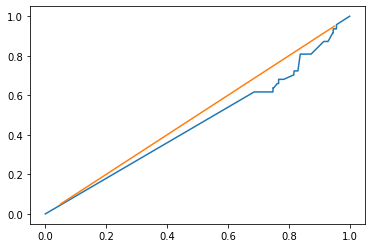

In [95]:
plt.plot(fpr, tpr)
plt.plot(probs,probs)

In [101]:
threshold_dist = 1e-2
probs = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
res = []
for v_th_prob in probs:
  v_thresholds = {}
  for key in excoefs.keys():
    V = np.sqrt(np.sum(excoefs[key][:2,:]**2,axis=0))
    V = V[np.isfinite(V)]
    V = np.sort(V)
    v_th_idx = int(len(V)*(1-v_th_prob))
    if(len(V) == 0):
      v_thresholds[key] = np.infty
    else:
      v_thresholds[key] = V[v_th_idx]
    #plt.plot(V,np.linspace(0,1,len(V)))
    #plt.vlines(v_thresholds[key],0,1)
    #plt.xscale('log')
    #plt.show()
    #break
  signal_prob = []
  signal_magn = []
  for cnt, (date,row) in enumerate(earthquakes.iterrows()):
    match_cnt = 0
    alert_cnt = 0
    for cnt2, key in enumerate(excoefs.keys()):
       dist = distances[cnt,cnt2]
       if(dist <= threshold_dist):
         match = np.argwhere(stat_data[key].index==date).flatten()
         if(len(match)>0):
           match = match[0]
           v_matched = np.sqrt(np.sum(excoefs[key][:,match-W:match][:2,:]**2,axis=0))
           v_matched = v_matched[np.isfinite(v_matched)]
           if(len(v_matched) == W):
             match_cnt += 1
             if(np.max(v_matched) >= v_thresholds[key]):
               alert_cnt += 1
    if(match_cnt > 0):
      signal_prob.append(alert_cnt/match_cnt)
      signal_magn.append(row["m"])
  res.append( np.array(signal_prob) )
res = np.array(res)

In [115]:
cuts = (res[:,np.newaxis,:]>np.linspace(0,1,20).reshape(1,-1,1)).astype('int')

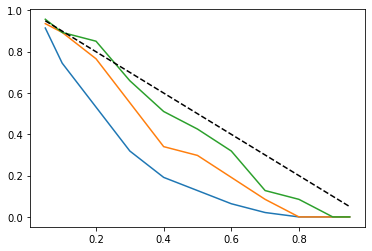

In [128]:
plt.plot(probs, 1-cuts[:,5,:].mean(axis=-1))
plt.plot(probs, 1-cuts[:,10,:].mean(axis=-1))
plt.plot(probs, 1-cuts[:,15,:].mean(axis=-1))
plt.plot(probs,1-np.array(probs), ls='dashed', c='black')
plt.show()

In [113]:
non_signaled = 1-cuts.sum(axis=2)/cuts.shape[2]

In [114]:
non_signaled.shape

(11, 20)

# Discard

In [ ]:
m_day = catalog["m"].groupby("Date").apply(lambda x : (2/3)*np.log10(np.sum(10**(1.5*x))))
true_days = m_day.index
m_day = m_day.values
lat_day = catalog["lat"].groupby("Date").mean().values
long_day = catalog["long"].groupby("Date").mean().values
dep_day = catalog["dep"].groupby("Date").mean().values

In [ ]:
catalog_day = pd.DataFrame(columns = ["m", "lat", "long", "dep" ])

In [ ]:
catalog_day["m"] = m_day
catalog_day["lat"] = lat_day
catalog_day["long"] = long_day
catalog_day["dep"] = dep_day
catalog_day.index = true_days

In [ ]:
catalog_day.to_csv("catalog_day.csv", sep="\t")